# PART B: Semi-DISCREte WGAN

In this numerical part, we consider the quadratic cost $c(x, y)=\|x-y\|_{2}^{2}$ on $\mathbf{R}^{d}$.

## 5.
Here $d=2$. Let $\Theta:=\left(\mathbf{R}^{2}\right)^{2}$. For $\theta=(a, b) \in \Theta$, we define $g_{\theta}:[0,1] \rightarrow \mathbf{R}^{2}$ by

$$
\forall z \in[0,1], \quad g_{\theta}(z)=z a+(1-z) b
$$

We denote by $\mu_{\theta}$ the distribution of $g_{\theta}(Z)$ where $Z$ is uniform in $[0,1]$.

Consider also the $\nu=\frac{1}{2} \delta_{y_{1}}+\frac{1}{2} \delta_{y_{2}}$ with $y_{1}=(-1,0)$ and $y_{2}=(1,0)$.

The above function $H$ related to $\left(\mu_{\theta}, \nu\right)$ will be denoted by $H_{\theta}$.

The goal of this question is to numerically solve $\min _{\theta \in \Theta} W\left(\mu_{\theta}, \nu\right)$.

### a. Can you guess a solution $\theta$ of this problem?

By denoting $m=\frac{y_{1}+y_{2}}{2}$, and $u=\frac{y_{2}-y_{1}}{2}$, we can guess that the solution is of the form $\theta=(m - \alpha u, m + \alpha u)$, with $\alpha$ a little larger than 1.

### b. For a fixed $\theta \in \Theta$, implement in Python the ASGD algorithm that approaches $v \in \operatorname{Argmax} H_{\theta}$.

In [2]:
import torch
import numpy as np

y = torch.Tensor([[-1, 0], [1, 0]])
q = torch.Tensor([0.5, 0.5])

def c(x, y):
    # print(x.shape, y.shape)
    return torch.norm(x - y, dim=2)

def compute_gradient(v, x):
    diff = c(x, y) - v
    _, i_min = torch.min(diff, axis=1)
    return q - torch.eye(len(v))[i_min]

In [3]:
from torch import nn
from torch.nn import functional as F

# implement ASGD algorithm
def asgd(theta, gamma, batch_size, max_iter):
    v_s = [torch.randn(len(y))]
    for t in range(1, max_iter+1):
        z = torch.rand(batch_size, 1, 1)
        x = z * theta[0] + (1 - z) * theta[1]

        # compute gradient
        grad = compute_gradient(v_s[-1], x).sum(0) / batch_size

        # update v
        v_s.append(v_s[-1] + gamma * grad / np.sqrt(t))

        if not t % 10:
            # compute H_v using Monte Carlo
            v = sum(v_s[1:]) / len(v_s[1:])
            z = torch.rand(100000, 1, 1)
            x = z * theta[0] + (1 - z) * theta[1]
            H_v = q.dot(v) + torch.min(c(x, y) - v, dim=1)[0].mean()
            # print(v, H_v)

    return sum(v_s[1:]) / max_iter

# test asgd
theta = torch.Tensor([[-1, 0], [1, 0]])
gamma = 0.1
batch_size = 100
max_iter = 1000
v = asgd(theta, gamma, batch_size, max_iter)

### 3. Compare your ASGD algorithm with the PyTorch implementation of ASGD.

In [4]:
# implement ASGD algorithm
def asgd_torch(theta, gamma, batch_size, max_iter):
    v = torch.randn(len(y))
    v = torch.nn.Parameter(v, requires_grad=True)

    optimizer = torch.optim.ASGD([v], lr=gamma)

    for t in range(1, max_iter+1):
        z = torch.rand(batch_size, 1, 1, requires_grad=False)
        x = z * theta[0] + (1 - z) * theta[1]

        optimizer.zero_grad()
        loss = - q.dot(v) - torch.min(c(x, y) - v, dim=1)[0].mean()
        loss.backward()
        optimizer.step()

        if not t % 10:
            # compute H_v using Monte Carlo
            z = torch.rand(100000, 1, 1)
            x = z * theta[0] + (1 - z) * theta[1]
            H_v = q.dot(v) + torch.min(c(x, y) - v, dim=1)[0].mean()
            print(v.detach().numpy(), H_v.detach().numpy())

    return v

# test asgd
theta = torch.Tensor([[-1, 0], [1, 0]])
gamma = 0.1
batch_size = 100
max_iter = 1000
v = asgd_torch(theta, gamma, batch_size, max_iter)

[0.05045909 0.7948715 ] 0.4298884
[0.22042772 0.6248184 ] 0.48068294
[0.3283809 0.5167807] 0.4960688
[0.3583389 0.4867382] 0.49931884
[0.3672998  0.47769275] 0.499018
[0.37825823 0.46664986] 0.4994679
[0.4042067  0.44061694] 0.49876472
[0.41715863 0.42758048] 0.49965984
[0.41811636 0.4265383 ] 0.4999929
[0.46004274 0.38452742] 0.4975436
[0.41003823 0.43444738] 0.49925283
[0.4010054 0.4433958] 0.4991552
[0.4039622 0.4403544] 0.49980584
[0.4159092 0.428323 ] 0.49945998
[0.4428371 0.4013106] 0.49911603
[0.4078348  0.43622842] 0.4987865
[0.40280014 0.44117856] 0.5006962
[0.40176135 0.44213295] 0.5002154
[0.39772674 0.44608313] 0.49920118
[0.42564493 0.41808045] 0.50256306
[0.42759907 0.41604188] 0.5009558
[0.42855465 0.4150021 ] 0.500316
[0.42951044 0.4139624 ] 0.49908295
[0.4344588 0.4089302] 0.49952853
[0.41445324 0.428852  ] 0.4995301
[0.4084239  0.43479744] 0.5010115
[0.4183629  0.42477462] 0.5009973
[0.40934038 0.43371326] 0.499724
[0.3993215 0.4436484] 0.49984872
[0.4122525  0.430633

### d. In Python, implement an algorithm that approaches the minimum of θ → W(µθ, ν)

In [5]:
import matplotlib.pyplot as plt

def minimize_OT(alpha, gamma, batch_size, max_iter, display_ot=True):
    theta = torch.randn(2, y.shape[1])
    theta = torch.nn.Parameter(theta, requires_grad=True)

    optimizer_theta = torch.optim.Adam([theta], lr=alpha)

    v = torch.randn(y.shape[0])
    v = torch.nn.Parameter(v, requires_grad=True)

    optimizer_v = torch.optim.ASGD([v], lr=gamma)

    for t in range(1, max_iter+1):
        z = torch.rand(batch_size, 1, 1, requires_grad=False)

        optimizer_v.zero_grad()
        x = z * theta[0] + (1 - z) * theta[1]
        loss = - q.dot(v) - torch.min(c(x, y) - v, dim=1)[0].mean()
        loss.backward()
        optimizer_v.step()

        optimizer_theta.zero_grad()
        x = z * theta[0] + (1 - z) * theta[1]
        loss = q.dot(v) + torch.min(c(x, y) - v, dim=1)[0].mean()
        loss.backward()
        optimizer_theta.step()

        if not t % 100:
            # compute H_v using Monte Carlo
            z = torch.rand(100000, 1, 1)
            x = z * theta[0] + (1 - z) * theta[1]
            H_v = q.dot(v) + torch.min(c(x, y) - v, dim=1)[0].mean()
            # print(theta.detach().numpy(), v.detach().numpy(), H_v.detach().numpy())
            print(H_v.detach().numpy())

            # Plot the transport plan
            if display_ot:
                plt.scatter(y[:, 0], y[:, 1], c='r')
                plt.scatter(theta.detach().numpy()[:, 0], theta.detach().numpy()[:, 1], c='b')
                plt.scatter(x.detach().numpy()[:100, 0, 0], x.detach().numpy()[:100, 0, 1], c='g', alpha=0.1)
                plt.xlim(-2, 2)
                plt.ylim(-2, 2)
                plt.show() 

    return theta, v

1.0209732


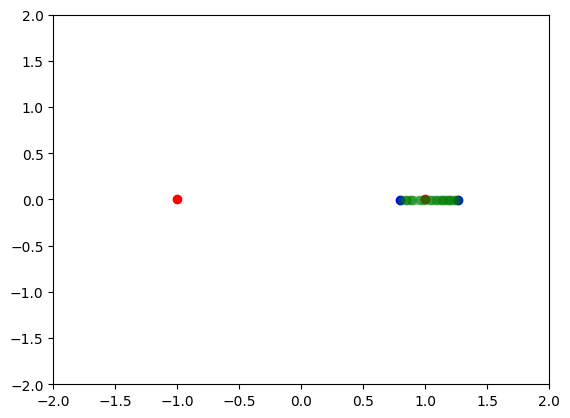

0.506364


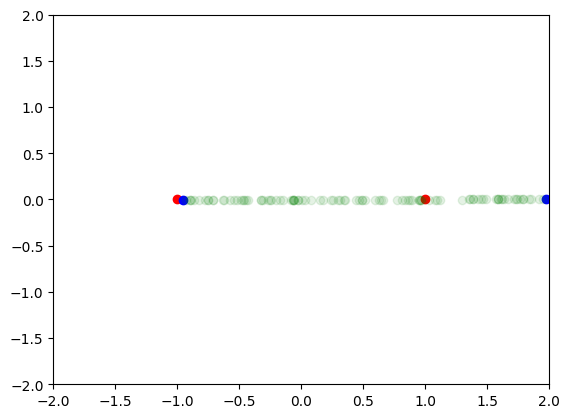

0.41637376


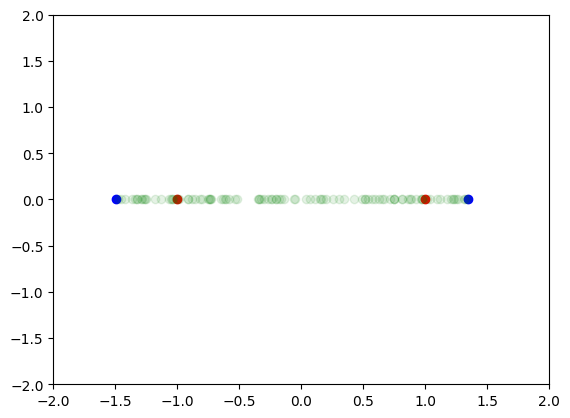

0.41279697


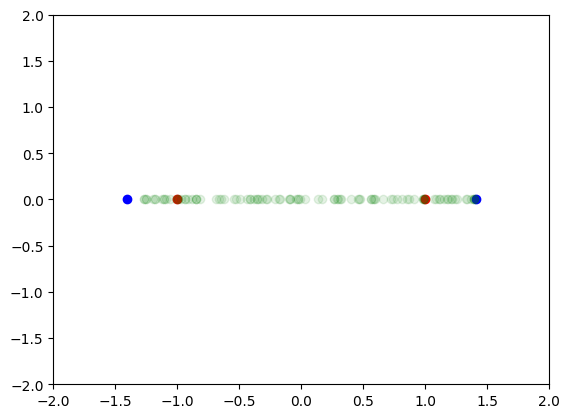

0.4157574


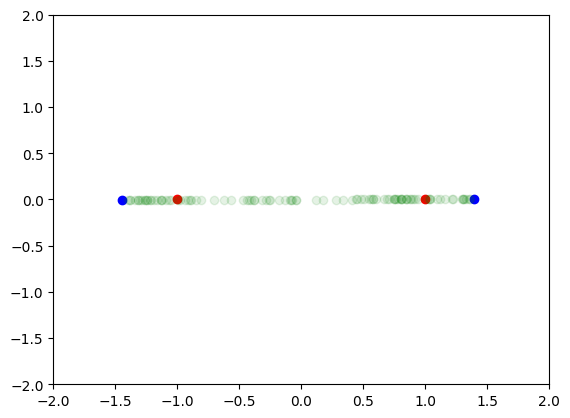

0.4156791


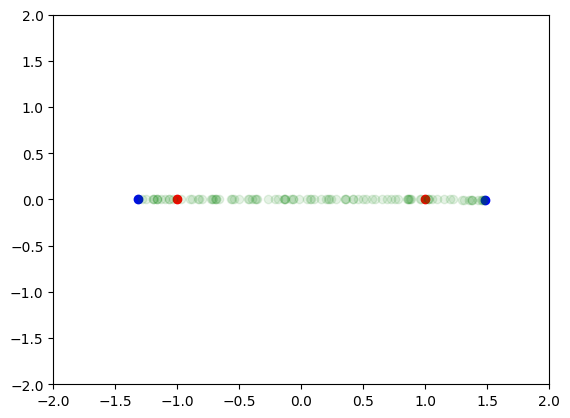

0.41416466


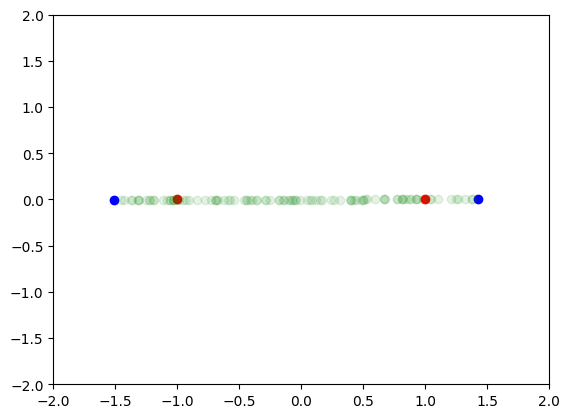

0.4149729


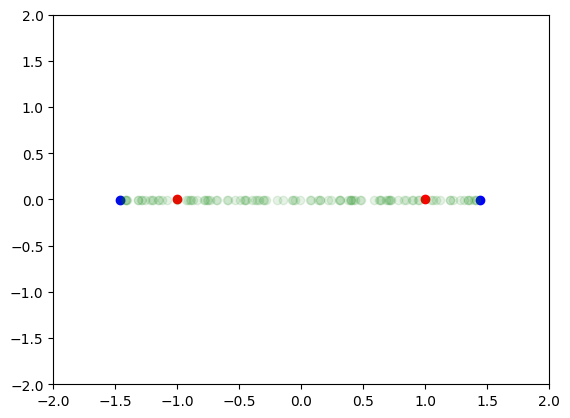

0.41484767


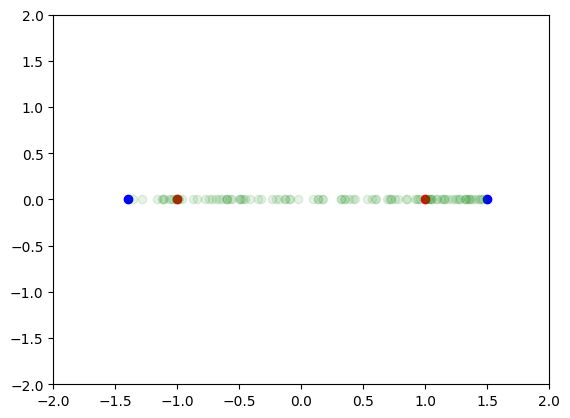

0.4155244


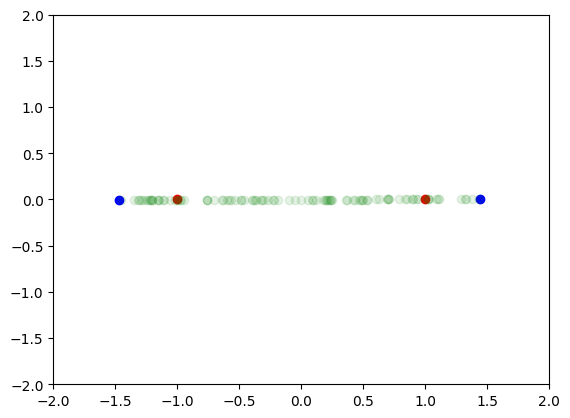

In [6]:
# test minimize_OT
alpha = 0.1
gamma = 0.1

batch_size = 100
max_iter = 1000
theta, v = minimize_OT(alpha, gamma, batch_size, max_iter)

### e. Illustrate the behavior of the algorithm by displaying the configurations obtained along the algorithm (by drawing samples of µθ). Is the behavior stable if you vary the optimization parameters?

When we vary the optimization parameters, the behavior is not stable.

**Example 1: $\alpha$ > $\gamma$**

1.0233791


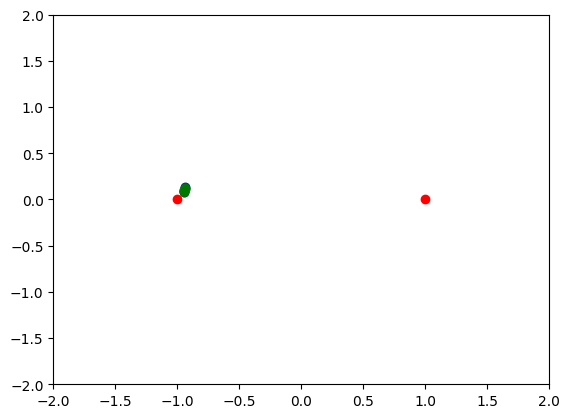

0.71962965


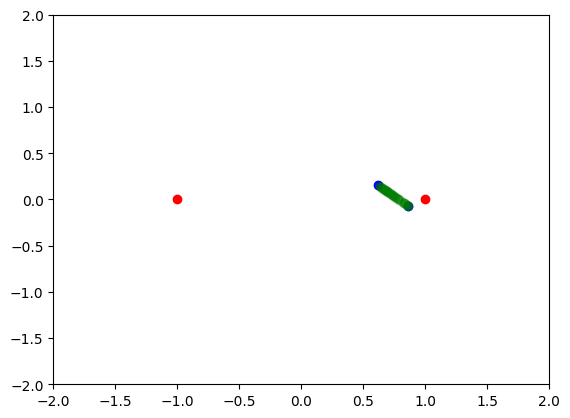

0.5701173


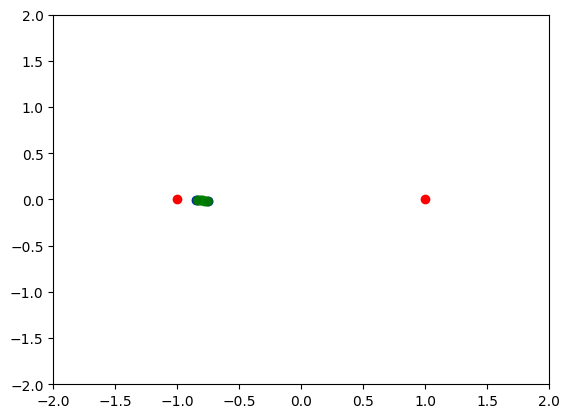

0.6191685


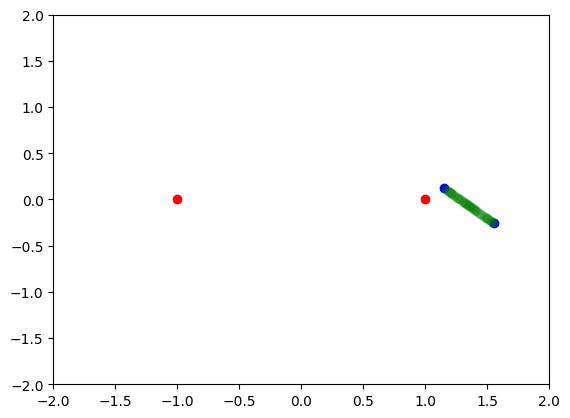

0.5502245


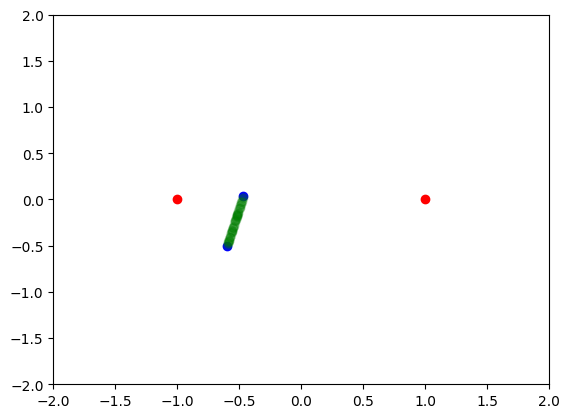

0.407078


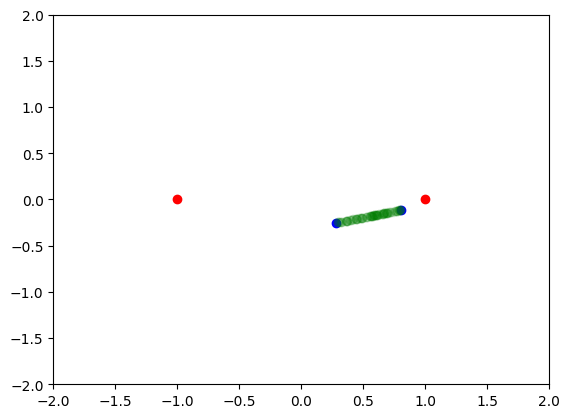

0.5986421


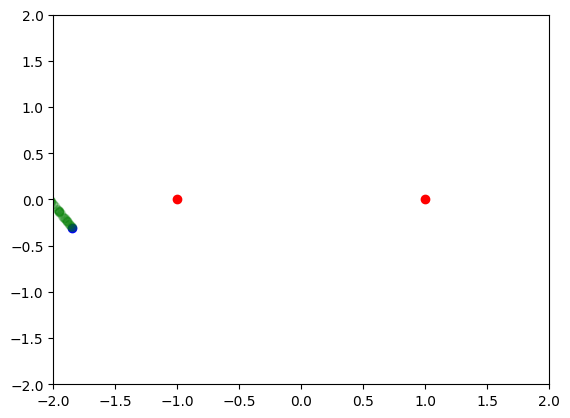

0.540713


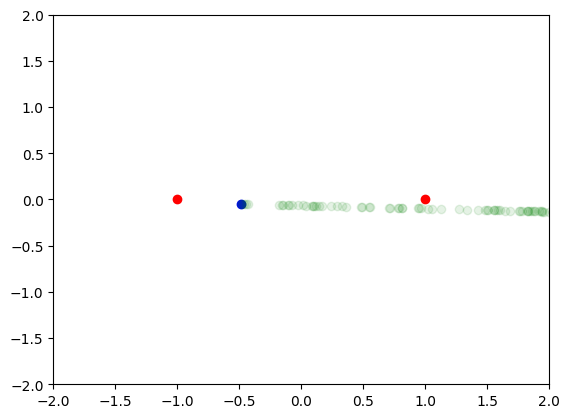

0.41162387


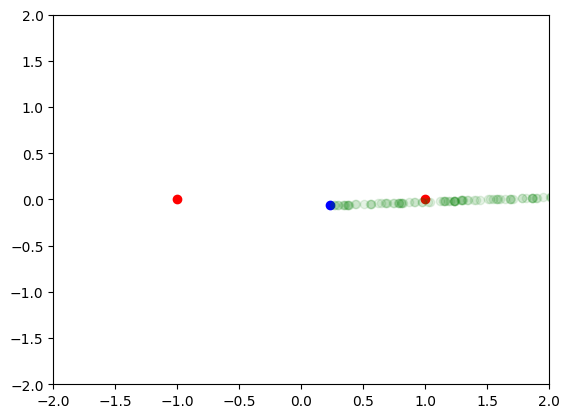

0.3589512


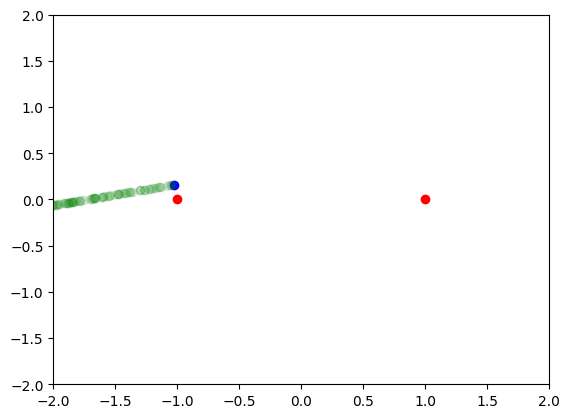

In [7]:
# test minimize_OT
alpha = 1.0
gamma = 0.1

batch_size = 100
max_iter = 1000
theta, v = minimize_OT(alpha, gamma, batch_size, max_iter)

**Example 2: $\alpha$ < $\gamma$**

0.30880916


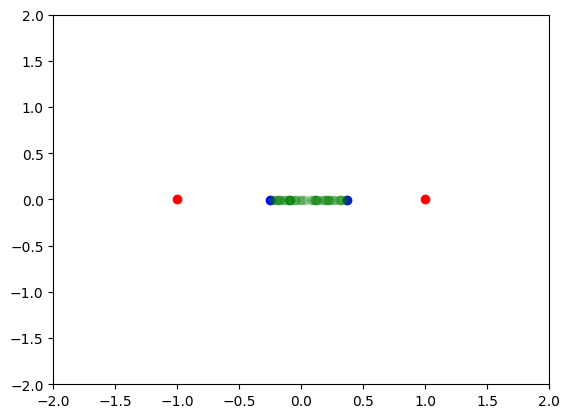

0.32082123


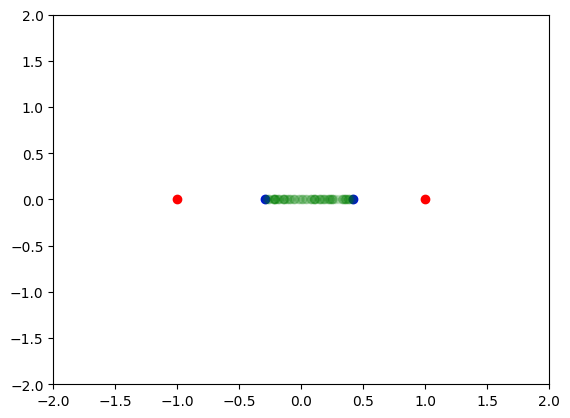

0.33036655


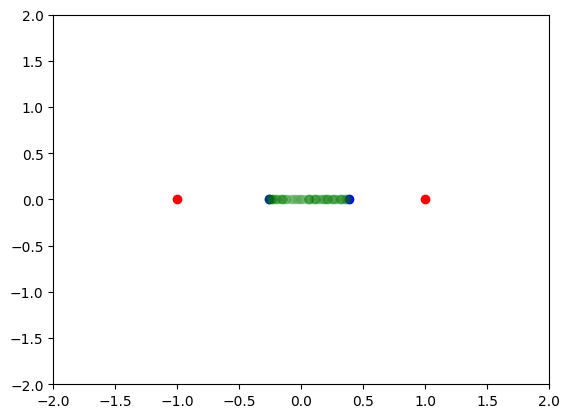

0.33934516


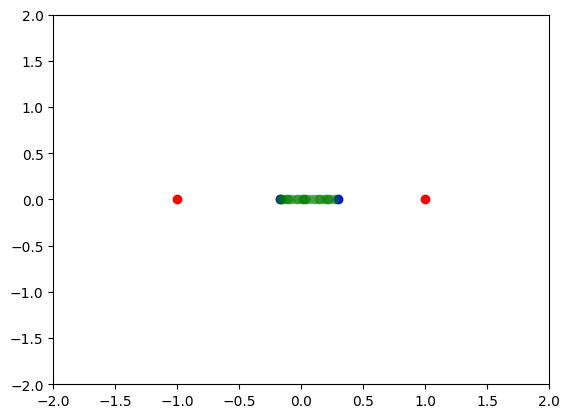

0.34767842


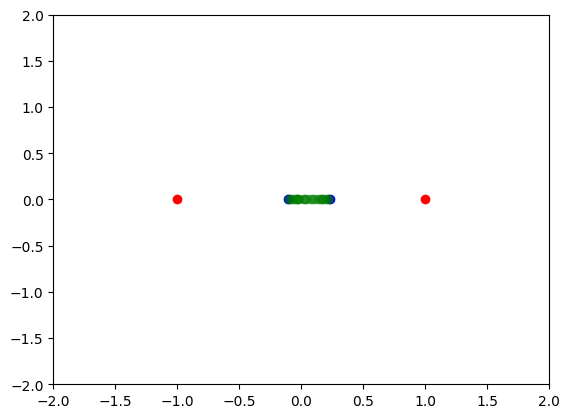

0.35659212


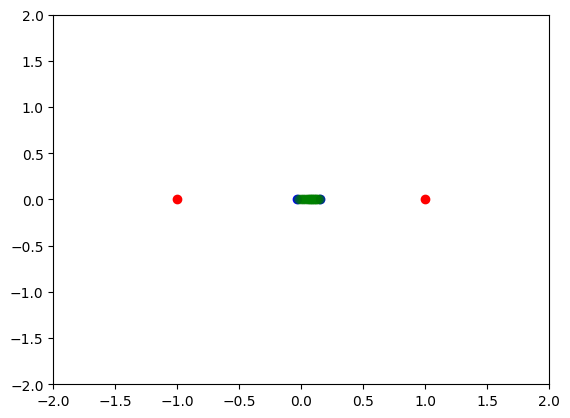

0.36440575


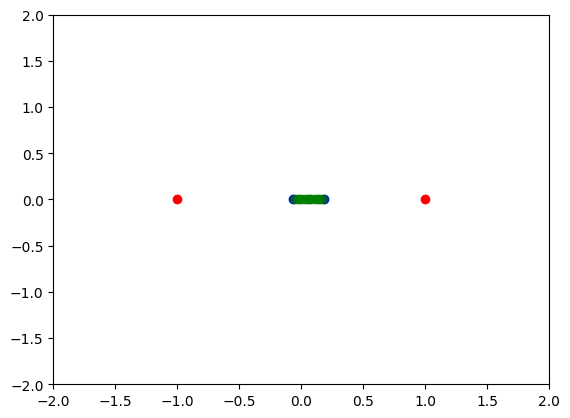

0.37286353


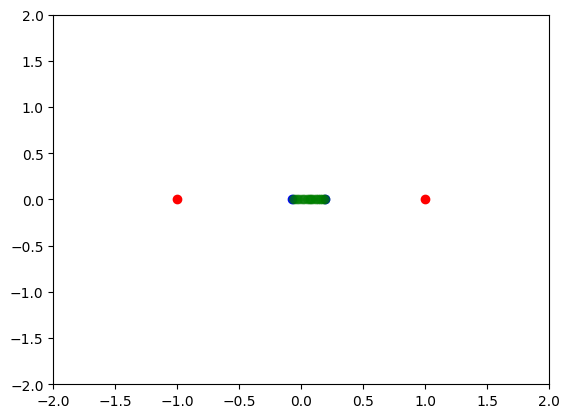

0.38002622


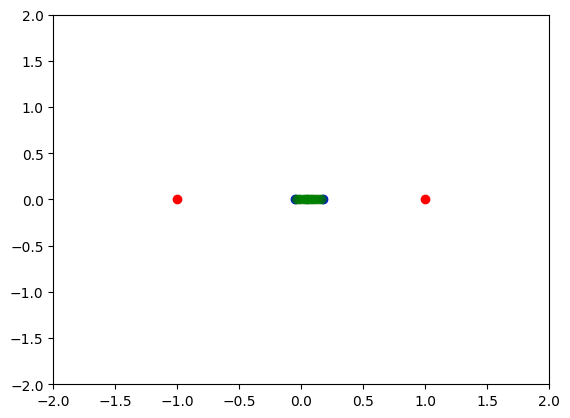

0.38736206


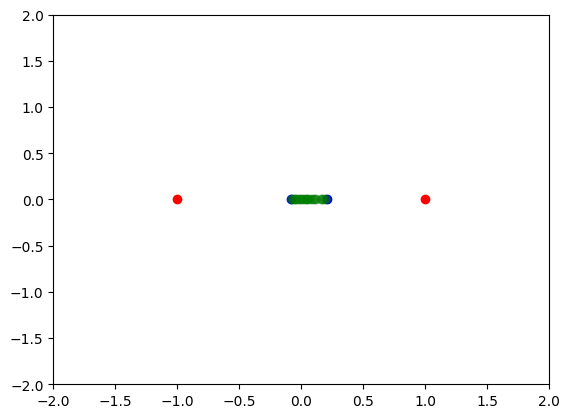

In [8]:
# test minimize_OT
alpha = 0.1
gamma = 10.0

batch_size = 100
max_iter = 1000
theta, v = minimize_OT(alpha, gamma, batch_size, max_iter)

### f. Is there some configuration of µθ for which the optimization of v may be singular?

In [9]:
# Test asgd_torch with a singular µθ distribution
theta = torch.Tensor([[0, 0], [0, 0]])
gamma = 0.1
batch_size = 100
max_iter = 1000
v = asgd_torch(theta, gamma, batch_size, max_iter)

[-0.6795691  -0.72779274] 0.97588795
[-0.67950034 -0.7277205 ] 0.97589004
[-0.67943156 -0.72764826] 0.975892
[-0.6793628 -0.727576 ] 0.9758936
[-0.679294  -0.7275038] 0.97589546
[-0.6792252  -0.72743154] 0.97589743
[-0.67915654 -0.7273593 ] 0.9758991
[-0.67908806 -0.72728705] 0.975901
[-0.6790196  -0.72721475] 0.9759027
[-0.678951  -0.7271425] 0.97590435
[-0.67888254 -0.72707033] 0.975906
[-0.67881405 -0.7269981 ] 0.97590786
[-0.6787455 -0.7269259] 0.9759098
[-0.678677  -0.7268536] 0.9759114
[-0.6786085 -0.7267814] 0.9759132
[-0.67854005 -0.7267092 ] 0.9759149
[-0.6784715 -0.726637 ] 0.975917
[-0.6784031 -0.7265647] 0.9759197
[-0.67833453 -0.7264925 ] 0.97592163
[-0.67826605 -0.72642034] 0.9759232
[-0.67819756 -0.72634804] 0.97592485
[-0.6781291  -0.72627604] 0.9759264
[-0.6780608 -0.7262044] 0.9759282
[-0.67799264 -0.7261327 ] 0.9759292
[-0.6779244 -0.7260611] 0.97593224
[-0.67785615 -0.72598946] 0.97593343
[-0.677788   -0.72591776] 0.9759351
[-0.6777198 -0.7258461] 0.9759363
[-0.6776

## 6.
The goal of this last question is to learn a generative model µθ for the MNIST dataset.
You may download the MNIST dataset as in Practical Session 3. If you need, you may work on a
subsampled version of MNIST (e.g. with 6000 points, 600 for each class).

In [26]:
# Load MNIST data (6000 samples, 600 samples per digit)
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

mnist_trainset.data = mnist_trainset.data[:6000]
mnist_trainset.targets = mnist_trainset.targets[:6000]

y = mnist_trainset.data.view(-1, 28*28).float() / 255
q = torch.ones(len(y)) / len(y)

print(y.shape, q.shape)

torch.Size([6000, 784]) torch.Size([6000])


In [37]:
# Size  of generator input
nz = 32

# Size of feature maps in generator and discriminator
ngf = 32

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh(),
            # output size. 1 x 28 x 28
            nn.Flatten(),
            # output size. 1 x 784
        )

    def forward(self, input):
        return self.main(input)

In [38]:
def minimize_OT_MNIST(alpha, gamma, batch_size, max_iter):

    # Create the generator
    netG = Generator()
    optimizer_theta = torch.optim.Adam(netG.parameters(), lr=alpha)

    v = torch.randn(y.shape[0])
    v = torch.nn.Parameter(v, requires_grad=True)

    optimizer_v = torch.optim.ASGD([v], lr=gamma)

    for t in range(1, max_iter+1):
        z = torch.rand(batch_size, nz, 1, 1, requires_grad=False)

        optimizer_v.zero_grad()
        x = netG(z).view(batch_size, 1, 28*28)
        loss = - q.dot(v) - torch.min(c(x, y) - v, dim=1)[0].mean()
        loss.backward()
        optimizer_v.step()

        optimizer_theta.zero_grad()
        x = netG(z).view(batch_size, 1, 28*28)
        loss = q.dot(v) + torch.min(c(x, y) - v, dim=1)[0].mean()
        loss.backward()
        optimizer_theta.step()

        if not t % 10:
            # compute H_v using Monte Carlo
            z = torch.rand(64, nz, 1, 1)
            x = netG(z).view(64, 1, 28*28)
            H_v = q.dot(v) + torch.min(c(x, y) - v, dim=1)[0].mean()
            # print(theta.detach().numpy(), v.detach().numpy(), H_v.detach().numpy())
            print(H_v.detach().numpy())

    return netG, v

### a. Adapt the algorithm of the previous question in order to learn a generative model for MNIST.

11.146286
10.1142845
8.988201
8.358487
7.5567527
6.829068
6.0969462
5.608785
4.477884
3.8442385
2.241853
1.1219944
1.0729771
1.1567037
0.9674796
1.560229
1.5472554
1.6910019
1.4890852
1.3667557
1.5432937
1.6343439
1.696031
2.2163124
1.7153032


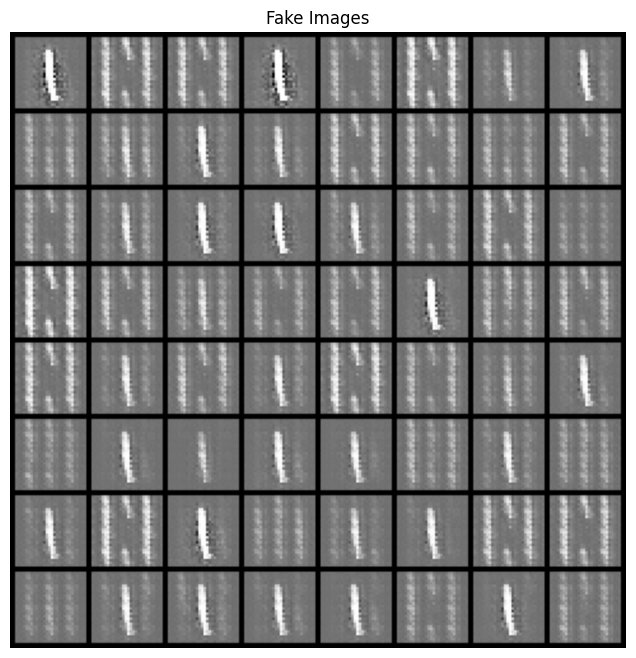

In [40]:
# test minimize_OT
alpha = 0.001
gamma = 0.1

batch_size = 16
max_iter = 250
generator, v = minimize_OT_MNIST(alpha, gamma, batch_size, max_iter)

# Print examples of generated images
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Generate batch of latent vectors
batch_size = 64
fixed_noise = torch.randn(batch_size, nz, 1, 1)

# Generate fake image batch with G
fake = generator(fixed_noise).view(-1, 1, 28, 28)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True).detach().numpy(), (1,2,0)))
plt.show()

### b. For a fixed configuration of µθ, illustrate the behavior of ASGD to estimate W(µθ, ν).

0.9563557
1.951847
2.3386981
2.578449
2.756317
2.8895829
2.9999166
3.0878685
3.1687639
3.2455473
3.320787
3.3796532
3.4558368
3.5022662
3.5644882
3.5969565
3.6428216
3.6884995
3.7236993
3.7702634
3.803833
3.824374
3.861829
3.899491
3.9188502


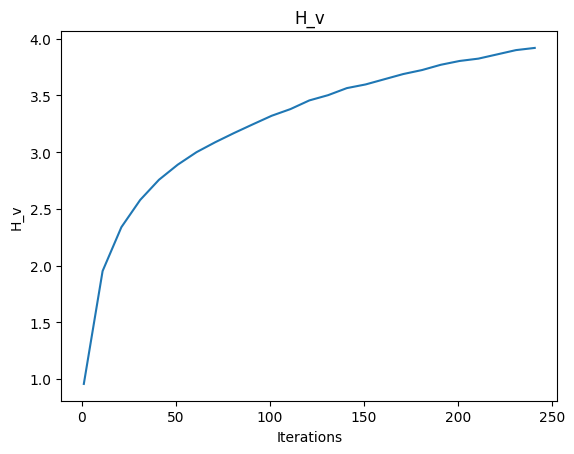

In [43]:
# For a fixed configuration of µθ, illustrate the behavior of ASGD to estimate W(µθ, ν).
def asgd_torch_MNIST(generator, gamma, batch_size, max_iter):
    v = torch.randn(y.shape[0])
    v = torch.nn.Parameter(v, requires_grad=True)

    list_H_v = []

    optimizer = torch.optim.ASGD([v], lr=gamma)

    for t in range(1, max_iter+1):
        z = torch.rand(batch_size, nz, 1, 1, requires_grad=False)
        x = generator(z).view(batch_size, 1, 28*28)

        optimizer.zero_grad()
        loss = - q.dot(v) - torch.min(c(x, y) - v, dim=1)[0].mean()
        loss.backward()
        optimizer.step()

        if not t % 10:
            # compute H_v using Monte Carlo
            z = torch.rand(64, nz, 1, 1)
            x = generator(z).view(64, 1, 28*28)
            H_v = q.dot(v) + torch.min(c(x, y) - v, dim=1)[0].mean()
            print(H_v.detach().numpy())
            list_H_v.append(H_v.detach().numpy())

    plt.title("H_v")
    plt.plot(np.arange(1, max_iter+1, 10), list_H_v)
    plt.xlabel("Iterations")
    plt.ylabel("H_v")
    plt.show()

    return v

# test asgd_torch_MNIST
gamma = 0.1
batch_size = 16
max_iter = 250
v = asgd_torch_MNIST(generator, gamma, batch_size, max_iter)

### c. Can you propose a better parameterization of the dual variable v for which the learning would be faster?